## モジュールのインポートなど

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6
from sklearn.datasets import make_classification
import random


In [18]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)

    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    # initialise and raise input errors
    def __init__(self, n_arms):
        if not type(n_arms)==int:
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms

    @abstractmethod
    # raise input errors
    def play(self, context):
        """Play a round

        Parameters
        ----------
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.

        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set
            {0, ..., n_arms - 1}.
        """
        if not type(context) == np.ndarray:
            raise TypeError("`context` must be numpy.ndarray")
        if not context.shape == (n_arms, n_dims):
            raise TypeError("`context` must have shape (n_arms, n_dims)")
        self.context = context


    @abstractmethod
    # raise input errors
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play

        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.

        reward : float
            Reward received from the arm.

        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The
            0-th axis indexes the arms, and the 1-st axis indexes the
            features. Non-contextual bandits accept a context of None.
        """
        if not (type(arm) == int or arm.dtype == 'int32'):  # 元は64だが，データが32で読み込まれているので，32にしてある
            raise TypeError("`arm` must be int type")
        if not (arm >= 0 and arm <= (n_arms-1)):
            raise ValueError("`arm` must be the the set {0, .., n_arms - 1}")
        if not (type(reward) == float or reward.dtype == 'float64'):
            raise TypeError("`reward` must be float type")
        if not (context.shape == (n_arms, n_dims) and context.dtype == 'float64') :
            raise TypeError("`context` must be float numpy in shape (n_events, n_arms, n_dims)")
        # get the values
        self.arm = arm
        self.reward = reward
        self.context = context



In [21]:
# Define global functions
# 推定最適行動が複数ある場合，その中からランダムで行動を選ぶグローバル関数．
def break_tie(_range):
    indices = np.argwhere(_range == np.max(_range))
    index = np.random.randint(0,len(indices))

    return indices[index][0]


## Adultデータセットを適用(文脈変数の切り落とし方はどうしよう，でSTOP)

In [2]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [3]:
print(type(X))
display(X)


<class 'pandas.core.frame.DataFrame'>


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [9]:
print(type(y))
display(y)


<class 'pandas.core.frame.DataFrame'>


,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
48837,<=50K.
48838,<=50K.
48839,<=50K.
48840,<=50K.


In [4]:
display(y["income"].unique())


array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

In [5]:
y["income"] = y["income"].apply(lambda row: 1 if row == "<=50K" or row == "<=50K." else 0)
print(type(y))
display(y)


<class 'pandas.core.frame.DataFrame'>


C:\Users\hjhhd\AppData\Local\Temp\ipykernel_15092\4252442138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["income"] = y["income"].apply(lambda row: 1 if row == "<=50K" or row == "<=50K." else 0)


,income
0,1
1,1
2,1
3,1
4,1
...,...
48837,1
48838,1
48839,1
48840,1


In [6]:
length = len(X)
n_arms = len(y["income"].unique())

X["arm"] = np.random.randint(0, 2, size=length)
display(X["arm"])


0        0
1        0
2        1
3        0
4        0
        ..
48837    0
48838    0
48839    1
48840    0
48841    1
Name: arm, Length: 48842, dtype: int32

In [7]:
X["income"] = y
X["reward"] = X.apply(lambda row: 1 if row['arm'] == row['income'] else 0, axis=1)
X = X.drop("income", axis=1)
display(X["reward"])
display(X)


0        0
1        0
2        1
3        0
4        0
        ..
48837    0
48838    0
48839    1
48840    0
48841    0
Name: reward, Length: 48842, dtype: int64

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,arm,reward
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1,1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0,0
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,0,0
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,1,1
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0,0


In [8]:
X["income"] = y
X = X.dropna()
y = X["income"]
display(X)
display(y)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,arm,reward,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,0,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0,1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1,1,1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,0,1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0,0,1
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0,0,1
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,1,1,1
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0,0,1


0        1
1        1
2        1
3        1
4        1
        ..
48836    1
48837    1
48839    1
48840    1
48841    0
Name: income, Length: 47621, dtype: int64

文字列で表されるデータをダミー変数化

In [10]:
for col_name, col_data in X.items():
    if type(col_data.iloc[0]) == str:
        X_encoded = pd.get_dummies(col_data, prefix=col_name)
        X = pd.concat([X, X_encoded], axis=1)
        X.drop(col_name, axis=1, inplace=True)


In [11]:
display(X)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,arm,reward,income,workclass_?,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,1,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,0,0,1,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,1,1,1,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,0,0,1,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,0,0,1,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,245211,13,0,0,40,0,0,1,False,...,False,False,False,False,False,False,False,True,False,False
48837,39,215419,13,0,0,36,0,0,1,False,...,False,False,False,False,False,False,False,True,False,False
48839,38,374983,13,0,0,50,1,1,1,False,...,False,False,False,False,False,False,False,True,False,False
48840,44,83891,13,5455,0,40,0,0,1,False,...,False,False,False,False,False,False,False,True,False,False


In [9]:
# for col_name, col_data in X.items():
#     display(col_name)
#     display(col_data)
#     display(col_data.iloc[0])
#     break


'age'

0        39
1        50
2        38
3        53
4        28
         ..
48836    33
48837    39
48839    38
48840    44
48841    35
Name: age, Length: 47621, dtype: int64

39

In [12]:
X = X.drop("income", axis=1)
tmp_X = X[["arm", "reward"]]
X = X.drop(["arm", "reward"], axis=1)
display(X)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,245211,13,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
48837,39,215419,13,0,0,36,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
48839,38,374983,13,0,0,50,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
48840,44,83891,13,5455,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [13]:
# データ読み込み
arms = tmp_X["arm"]
arms, rewards = arms.to_numpy(), tmp_X["reward"].to_numpy()
arms = arms.astype(int)
rewards = rewards.astype(float)

context = X
contexts = X
for i in range(n_arms-1):
    contexts = pd.concat([contexts, context], axis=1)
contexts = contexts.to_numpy()

contexts = contexts.astype(float)
display(contexts)

n_arms = len(np.unique(arms))
n_events = len(contexts)  # ラウンド数：10000
n_dims = int(len(contexts[0])/n_arms)  # 100次元/10種の行動 = 10次元？ -> 行動ごとに10次元ずつ文脈変数が与えられている -> 見た所それぞれ違う実現値が入っているが，これはふさわしいのか？
contexts = contexts.reshape(n_events, n_arms, n_dims)

display(n_arms)
display(contexts)
print(n_dims)


array([[3.90000e+01, 7.75160e+04, 1.30000e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.00000e+01, 8.33110e+04, 1.30000e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.80000e+01, 2.15646e+05, 9.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [3.80000e+01, 3.74983e+05, 1.30000e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.40000e+01, 8.38910e+04, 1.30000e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.50000e+01, 1.82148e+05, 1.30000e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00]])

2

array([[[3.90000e+01, 7.75160e+04, 1.30000e+01, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00],
        [3.90000e+01, 7.75160e+04, 1.30000e+01, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[5.00000e+01, 8.33110e+04, 1.30000e+01, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00],
        [5.00000e+01, 8.33110e+04, 1.30000e+01, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[3.80000e+01, 2.15646e+05, 9.00000e+00, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00],
        [3.80000e+01, 2.15646e+05, 9.00000e+00, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00]],

       ...,

       [[3.80000e+01, 3.74983e+05, 1.30000e+01, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00],
        [3.80000e+01, 3.74983e+05, 1.30000e+01, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00]],

       [[4.40000e+01, 8.38910e+04, 1.30000e+01, ..., 1.00000e+00,
         0.00000e+00, 0.00000e+00],
        [4.40000e+01, 8.38910e+04, 1.30000e+01, ..., 1.00000e

108


### SoilTYpeをひとまとめに(ボツ)

In [16]:
# soil_typeをひとまとめにする
soil_list = []
for i in range(1, 41):
    tmp_name = f"Soil_Type{i}"
    soil_list.append(tmp_name)

soils = X[soil_list]
display(soils)


,,,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
2596,51,3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2590,56,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2804,139,9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2785,155,18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2595,45,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,153,20,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2391,152,19,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2386,159,17,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2384,170,15,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Soil_Type{n}が1であればnが要素として入るような列"Soil_Type"を作成
# すんなりうまくいったので，全てのデータは必ず1~40のどれかの種類に属していることが分かる
Soil_Type = []
for row in soils.itertuples():
    for i, soiltype in enumerate(row[1:]):
        if soiltype == 1:
            Soil_Type.append(i+1)
            break

X["Soil_Type"] = Soil_Type
display(X)


,,,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Soil_Type
2596,51,3,258,0,510,221,232,148,6279,1,0,0,...,0,0,0,0,0,0,0,0,5,29
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,...,0,0,0,0,0,0,0,0,5,29
2804,139,9,268,65,3180,234,238,135,6121,1,0,0,...,0,0,0,0,0,0,0,0,2,12
2785,155,18,242,118,3090,238,238,122,6211,1,0,0,...,0,0,0,0,0,0,0,0,2,30
2595,45,2,153,-1,391,220,234,150,6172,1,0,0,...,0,0,0,0,0,0,0,0,5,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,153,20,85,17,108,240,237,118,837,0,0,1,...,0,0,0,0,0,0,0,0,3,2
2391,152,19,67,12,95,240,237,119,845,0,0,1,...,0,0,0,0,0,0,0,0,3,2
2386,159,17,60,7,90,236,241,130,854,0,0,1,...,0,0,0,0,0,0,0,0,3,2
2384,170,15,60,5,90,230,245,143,864,0,0,1,...,0,0,0,0,0,0,0,0,3,2


In [20]:
# 従来のone-hotベクトル列を削除
for i in range(1, 41):
    tmp_name = f"Soil_Type{i}"
    # print(tmp_name)
    X = X.drop(tmp_name, axis=1)  # 配列のappend等と違い，ちゃんと代入する形にしないと変数には反映されない

display(X)


,,,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Cover_Type,Soil_Type
2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,5,29
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,5,29
2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,2,12
2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,2,30
2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,5,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,153,20,85,17,108,240,237,118,837,0,0,1,0,3,2
2391,152,19,67,12,95,240,237,119,845,0,0,1,0,3,2
2386,159,17,60,7,90,236,241,130,854,0,0,1,0,3,2
2384,170,15,60,5,90,230,245,143,864,0,0,1,0,3,2


### つづき

In [69]:
X = X.set_axis(list(range(581012)), axis='index')
display(X)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,258,0,510,221,232,148,6279,1,0,0,...,0,0,0,0,0,0,0,0,0,5
1,212,-6,390,220,235,151,6225,1,0,0,...,0,0,0,0,0,0,0,0,0,5
2,268,65,3180,234,238,135,6121,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,242,118,3090,238,238,122,6211,1,0,0,...,0,0,0,0,0,0,0,0,0,2
4,153,-1,391,220,234,150,6172,1,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,85,17,108,240,237,118,837,0,0,1,...,0,0,0,0,0,0,0,0,0,3
581008,67,12,95,240,237,119,845,0,0,1,...,0,0,0,0,0,0,0,0,0,3
581009,60,7,90,236,241,130,854,0,0,1,...,0,0,0,0,0,0,0,0,0,3
581010,60,5,90,230,245,143,864,0,0,1,...,0,0,0,0,0,0,0,0,0,3


In [70]:
y = X["Cover_Type"]
X = X.drop("Cover_Type", axis=1)
display(X)
display(y)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,258,0,510,221,232,148,6279,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,212,-6,390,220,235,151,6225,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,268,65,3180,234,238,135,6121,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,242,118,3090,238,238,122,6211,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,153,-1,391,220,234,150,6172,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,85,17,108,240,237,118,837,0,0,1,...,0,0,0,0,0,0,0,0,0,0
581008,67,12,95,240,237,119,845,0,0,1,...,0,0,0,0,0,0,0,0,0,0
581009,60,7,90,236,241,130,854,0,0,1,...,0,0,0,0,0,0,0,0,0,0
581010,60,5,90,230,245,143,864,0,0,1,...,0,0,0,0,0,0,0,0,0,0


0         5
1         5
2         2
3         2
4         5
         ..
581007    3
581008    3
581009    3
581010    3
581011    3
Name: Cover_Type, Length: 581012, dtype: int64

In [23]:
# 説明変数のデータ概要（ひとまとめの状態）
display(X.describe())

# Elevation / quantitative /meters / Elevation in meters
# Aspect / quantitative / azimuth / Aspect in degrees azimuth
# Slope / quantitative / degrees / Slope in degrees
# Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features
# Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features
# Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway
# Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice
# Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice
# Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice
# Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points
# Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation
# Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation
# Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation

# 標高 / 量的 / メートル / メートル単位の標高
# 方位 / 量的 / 方位角 / 方位角（度
# 勾配 / 量的 / 度 / 勾配（度
# 水平距離 / 量的 / メートル / 最も近い地表水域までの距離
# 垂直距離_水文学 / 定量 / メートル / 最も近い地表水特徴までの垂直距離
# 水平距離_道路 / 量的 / メートル / 最も近い道路までの距離
# ヒルシェード_午前9時 / 定量的 / 0から255インデックス / 夏至の午前9時のヒルシェード指数
# Hillshade_Noon/定量的/0〜255インデックス/夏至正午の日影インデックス
# Hillshade_3pm / 定量 / 0から255のインデックス / 夏至の午後3時の日影インデックス
# Horizontal_Distance_To_Fire_Points / 量的 / メートル / 最も近い山火事の発火点までの水平距離
# Wilderness_Area（2進数4列） / 定性的 / 0（存在しない）または1（存在する） / 原生地域の指定
# Soil_Type (40 binary columns) / 定性的 / 0 (存在しない) または 1 (存在する) / 土壌タイプの指定
# Cover_Type（7種類） / 整数 / 1～7 / 森林被覆タイプの指定


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,24.362443
std,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,9.485405
min,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,20.000000
50%,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,29.000000
75%,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,1.000000,0.000000,1.000000,0.000000,31.000000
max,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,1.000000,1.000000,1.000000,1.000000,40.000000


In [71]:
# 特徴次元数と行動数を確認
print(f"説明変数次元数は：{len(X.columns)}")
print(f"行動の一覧は：{y.unique()}")
print(f"行動数は：{len(y.unique())}")

# 説明変数次元数は：51
# 行動の一覧は：[5 2 1 7 3 6 4]
# 行動数は：7


説明変数次元数は：51
行動の一覧は：[5 2 1 7 3 6 4]
行動数は：7


In [72]:
n_arms = len(y.unique())
length = len(X)

print(n_arms, length)


7 581012


In [73]:
# 行動はランダムに生成し，人工データの実験と同様にオフ方策評価の手法を取る
# 報酬は，ランダムに生成した行動と真のCoverTypeが同じであれば1，そうでない場合は0
X["arm"] = np.random.randint(1, 8, size=length)
X["Cover_Type"] = y
X["reward"] = X.apply(lambda row: 1 if row['arm'] == row['Cover_Type'] else 0, axis=1)
X = X.drop("Cover_Type", axis=1)

display(X)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,arm,reward
0,258,0,510,221,232,148,6279,1,0,0,...,0,0,0,0,0,0,0,0,7,0
1,212,-6,390,220,235,151,6225,1,0,0,...,0,0,0,0,0,0,0,0,7,0
2,268,65,3180,234,238,135,6121,1,0,0,...,0,0,0,0,0,0,0,0,2,1
3,242,118,3090,238,238,122,6211,1,0,0,...,0,0,0,0,0,0,0,0,7,0
4,153,-1,391,220,234,150,6172,1,0,0,...,0,0,0,0,0,0,0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,85,17,108,240,237,118,837,0,0,1,...,0,0,0,0,0,0,0,0,5,0
581008,67,12,95,240,237,119,845,0,0,1,...,0,0,0,0,0,0,0,0,6,0
581009,60,7,90,236,241,130,854,0,0,1,...,0,0,0,0,0,0,0,0,3,1
581010,60,5,90,230,245,143,864,0,0,1,...,0,0,0,0,0,0,0,0,3,1


In [74]:
# データ読み込み
minus_one = lambda x: x-1
arms = X["arm"].apply(lambda x: x-1)  # 一列しかないので，axis=は要らない
arms, rewards = arms.to_numpy(), X["reward"].to_numpy()
arms = arms.astype(int)
rewards = rewards.astype(float)

context = X.iloc[:, :-2]
contexts = X.iloc[:, :-2]
for i in range(n_arms-1):
    contexts = pd.concat([contexts, context], axis=1)
contexts = contexts.to_numpy()

contexts = contexts.astype(float)
display(contexts)

n_arms = len(np.unique(arms))
n_events = len(contexts)  # ラウンド数：10000
n_dims = int(len(contexts[0])/n_arms)  # 100次元/10種の行動 = 10次元？ -> 行動ごとに10次元ずつ文脈変数が与えられている -> 見た所それぞれ違う実現値が入っているが，これはふさわしいのか？
contexts = contexts.reshape(n_events, n_arms, n_dims)

display(n_arms)
display(contexts)
print(n_dims)


array([[ 258.,    0.,  510., ...,    0.,    0.,    0.],
       [ 212.,   -6.,  390., ...,    0.,    0.,    0.],
       [ 268.,   65., 3180., ...,    0.,    0.,    0.],
       ...,
       [  60.,    7.,   90., ...,    0.,    0.,    0.],
       [  60.,    5.,   90., ...,    0.,    0.,    0.],
       [  60.,    4.,   67., ...,    0.,    0.,    0.]])

7

array([[[ 258.,    0.,  510., ...,    0.,    0.,    0.],
        [ 258.,    0.,  510., ...,    0.,    0.,    0.],
        [ 258.,    0.,  510., ...,    0.,    0.,    0.],
        ...,
        [ 258.,    0.,  510., ...,    0.,    0.,    0.],
        [ 258.,    0.,  510., ...,    0.,    0.,    0.],
        [ 258.,    0.,  510., ...,    0.,    0.,    0.]],

       [[ 212.,   -6.,  390., ...,    0.,    0.,    0.],
        [ 212.,   -6.,  390., ...,    0.,    0.,    0.],
        [ 212.,   -6.,  390., ...,    0.,    0.,    0.],
        ...,
        [ 212.,   -6.,  390., ...,    0.,    0.,    0.],
        [ 212.,   -6.,  390., ...,    0.,    0.,    0.],
        [ 212.,   -6.,  390., ...,    0.,    0.,    0.]],

       [[ 268.,   65., 3180., ...,    0.,    0.,    0.],
        [ 268.,   65., 3180., ...,    0.,    0.,    0.],
        [ 268.,   65., 3180., ...,    0.,    0.,    0.],
        ...,
        [ 268.,   65., 3180., ...,    0.,    0.,    0.],
        [ 268.,   65., 3180., ...,    0.,    

51


## Off-policy evaluation

In [14]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit

    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.

    arms : integer numpy.ndarray, shape (n_events,)
        Array containing the history of pulled arms, represented as integer
        indices in the set {0, ..., mab.n_arms}

    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.

    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms.
        The 0-th axis indexes the events in the history, the 1-st axis
        indexes the arms and the 2-nd axis indexed the features.

    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None,
        continue evaluating until the historical events are exhausted.

    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # initialise values and raise input errors
    if not (arms.shape == (n_events,) and arms.dtype == 'int32')  :  # int32でデータが読み込まれてたので，条件をint64ではなくint32にした．
        print(arms.shape)
        print(n_events)
        print(arms.dtype)
        raise TypeError("`arms` must be integer numpy in shape (n_events,)")
    if not rewards.shape == (n_events,) and rewards.dtype == 'float64' :
        raise TypeError("`rewards` must be float numpy in shape (n_events,)")
    if not contexts.shape == (n_events,n_arms, n_dims) and rewards.dtype == 'float64' :
        raise TypeError("`contexts` must be float numpy in shape (n_events, n_arms, n_dims)")
    if n_rounds == None:        # set n_rounds to infinite number to run until all data exhausted
        n_rounds = np.inf
    elif not type(n_rounds) == int:
        raise TypeError("`n_rounds` must be integer or default 'None'")

    n_round = 0     # データの行動=方策の行動となり，評価を行うことのできた回数(≠n_rounds: 設定する試行回数)
    R = []          # save the total payoff
    H = []          # save used historical events

    for i in range(n_events):
        if n_round == n_rounds:
            break
        arm = mab.play(contexts[i])
        if arm == arms[i]:                 # if historical data equals to chosen arm
            R.append(rewards[i])           # append the new rewards
            H.append([arms[i], rewards[i], contexts[i]])      # append the used events
            mab.update(arms[i], rewards[i], contexts[i])      # update the information
            n_round += 1

    # return rewards per play
    out = np.array(R)

    return out


In [15]:
# 詳細を見るために改造
def offlineEvaluate_forPrint(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit

    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.

    arms : integer numpy.ndarray, shape (n_events,)
        Array containing the history of pulled arms, represented as integer
        indices in the set {0, ..., mab.n_arms}

    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.

    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms.
        The 0-th axis indexes the events in the history, the 1-st axis
        indexes the arms and the 2-nd axis indexed the features.

    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None,
        continue evaluating until the historical events are exhausted.

    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # initialise values and raise input errors
    if not (arms.shape == (n_events,) and arms.dtype == 'int32')  :  # int32でデータが読み込まれてたので，条件をint64ではなくint32にした．
        print(arms.shape)
        print(n_events)
        print(arms.dtype)
        raise TypeError("`arms` must be integer numpy in shape (n_events,)")
    if not rewards.shape == (n_events,) and rewards.dtype == 'float64' :
        raise TypeError("`rewards` must be float numpy in shape (n_events,)")
    if not contexts.shape == (n_events,n_arms, n_dims) and rewards.dtype == 'float64' :
        raise TypeError("`contexts` must be float numpy in shape (n_events, n_arms, n_dims)")
    if n_rounds == None:        # set n_rounds to infinite number to run until all data exhausted
        n_rounds = np.inf
    elif not type(n_rounds) == int:
        raise TypeError("`n_rounds` must be integer or default 'None'")

    n_round = 0     # データの行動=方策の行動となり，評価を行うことのできた回数(≠n_rounds: 設定する試行回数)
    R = []          # save the total payoff
    H = []          # save used historical events

    for i in range(n_events):
        if n_round == n_rounds:
            break
        arm = mab.play(contexts[i], n_round)
        if arm == arms[i]:                 # if historical data equals to chosen arm
            R.append(rewards[i])           # append the new rewards
            H.append([arms[i], rewards[i], contexts[i]])      # append the used events
            mab.update(arms[i], rewards[i], contexts[i])      # update the information
            n_round += 1

    # return rewards per play
    out = np.array(R)

    return out


## 結果記録のための関数

In [16]:
def repeat_n_times(mab, is_print, arms, rewards, contexts, n):
    perform_list = []
    if is_print:
        for i in range(n):
            tmp_result = offlineEvaluate_forPrint(mab, arms, rewards, contexts, 1000)
            perform_list.append(np.mean(tmp_result))
            print(i)

        return perform_list, sum(perform_list) / n

    else:
        for i in range(n):
            tmp_result = offlineEvaluate(mab, arms, rewards, contexts, 1000)
            perform_list.append(np.mean(tmp_result))
            print(i)

        return perform_list, sum(perform_list) / n


## 1. ε-greedy MAB

In [19]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        if not (epsilon >= 0 and epsilon <= 1):
            raise ValueError("`epsilon` must be a number in [0,1]")
        if not type(epsilon) == float:
            raise TypeError("`epsilon` must be float")
        if not type(Q0) == float:
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")

        self.epsilon = epsilon
        self.q = np.full(n_arms, Q0)      # initialise q values
        self.rewards = np.zeros(n_arms)     # keep the total rewards per arm
        self.clicks = np.zeros(n_arms)      # count the pulled rounds per arm

    # select a random arm to explore or a arm with best rewards to exploit, then return the arm
    def play(self, context=None):
        super().play(context)
        if np.random.random_sample() <= self.epsilon:           #explore
            arm = np.random.randint(0,self.n_arms)
        else:
            arm = break_tie(self.q)
        return arm

    # update values
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += self.reward
        self.q[arm] = self.rewards[arm] / self.clicks[arm]


In [26]:
mab = EpsGreedy(2, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))


EpsGreedy average reward 0.728


In [29]:
# 10回繰り返し，最後にその平均値を算出する
# mab = EpsGreedy(3, 0.05)
perf_list, average_perf = repeat_n_times(mab, False, arms, rewards, contexts, 10)
print(perf_list)
print(average_perf)

# [0.337, 0.332, 0.329, 0.332, 0.333, 0.329, 0.33, 0.333, 0.334, 0.335]
# 0.33240000000000003


0
1
2
3
4
5
6
7
8
9
[0.337, 0.332, 0.329, 0.332, 0.333, 0.329, 0.33, 0.333, 0.334, 0.335]
0.33240000000000003


## 2. UCB MAB

In [27]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        if not rho > 0:
            raise ValueError("`rho` must be positive")
        if not (type(rho) == float and np.isreal(rho)):
            raise TypeError("`rho` must be real float")
        if not type(Q0) == float :
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")

        self.rho = rho
        self.q = np.full(n_arms, Q0)
        self.rewards = np.zeros(n_arms)
        self.avg_rewards = np.zeros(n_arms)
        self.clicks = np.zeros(n_arms)
        self.round = 0        # to count the number of round played

    def play(self, context=None):
        super().play(context)
        self.round += 1
        self.q = np.where(self.clicks != 0, self.avg_rewards + np.sqrt(self.rho * np.log10(self.round) / self.clicks), self.q)

        arm = break_tie(self.q)

        return int(arm)

    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += reward
        self.avg_rewards[arm] = self.rewards[arm]/ self.clicks[arm]


In [45]:
# warning control
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [28]:
mab = UCB(2, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('UCB average reward', np.mean(results_UCB))


C:\Users\hjhhd\AppData\Local\Temp\ipykernel_15092\553603724.py:34: RuntimeWarning: invalid value encountered in divide
  self.q = np.where(self.clicks != 0, self.avg_rewards + np.sqrt(self.rho * np.log10(self.round) / self.clicks), self.q)
C:\Users\hjhhd\AppData\Local\Temp\ipykernel_15092\553603724.py:34: RuntimeWarning: divide by zero encountered in divide
  self.q = np.where(self.clicks != 0, self.avg_rewards + np.sqrt(self.rho * np.log10(self.round) / self.clicks), self.q)


UCB average reward 0.734


In [33]:
perf_list, average_perf = repeat_n_times(mab, False, arms, rewards, contexts, 10)
print(perf_list)
print(average_perf)

# [0.321, 0.33, 0.333, 0.329, 0.335, 0.332, 0.33, 0.333, 0.335, 0.334]
# 0.33120000000000005


0
1
2
3
4
5
6
7
8
9
[0.321, 0.33, 0.333, 0.329, 0.335, 0.332, 0.33, 0.333, 0.335, 0.334]
0.33120000000000005


## 3. LinUCB contextual MAB

In [29]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, alpha):
        if not (type(n_dims) == int or n_dims.dtype == 'int64'):
            raise TypeError("`n_dims` must be integer type")
        if not (type(alpha) == float or alpha.dtype == 'float64'):
            raise TypeError("`alpha` must be float")
        if not (alpha > 0.0 and np.isreal(alpha)):
            raise ValueError("`alpha` must be positive real")

        super().__init__(n_arms)
        self.n_dims = n_dims
        self.alpha = alpha
        self.post_dist = np.zeros(n_dims)
        '''initialise keys and values; key is arm, A for covariance, inv_A for inverse of A,
                                        b for reward, theta for coefficient vector'''
        self.A = np.array(np.identity(n_dims))
        self.inv_A = [np.linalg.inv(self.A)]*10
        self.A  = [self.A]*10

        self.b = [np.zeros(n_dims)]*10
        self.theta = [(np.linalg.inv(np.identity(n_dims)) @  np.zeros(n_dims))]*10

    # return the best arm
    def play(self, context):
        super().play(context)
        # calculate posterior distribution of the coefficient vector
        for arm in range(self.n_arms):
            inv_A = self.inv_A[arm]
            theta = self.theta[arm]

            # calculate posterior distribution of the coefficient vector
            tmp_1 = self.post_dist[arm]
            tmp_2 = context[arm]
            self.post_dist[arm] = theta @ context[arm] + self.alpha * np.sqrt(context[arm].T @ inv_A @ context[arm])

        arm = break_tie(self.post_dist)
        return int(arm)

    # update dictionary
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        reshaped_context = context[arm].reshape(-1,1)   # reshape to the right form
        self.A[arm] = self.A[arm] + reshaped_context @ reshaped_context.T
        self.inv_A[arm] = np.linalg.inv(self.A[arm])
        self.b[arm] = self.b[arm] + reward * context[arm]
        self.theta[arm] = self.inv_A[arm] @ self.b[arm]




In [30]:
mab = LinUCB(2, 108, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('LinUCB average reward', np.mean(results_LinUCB))


LinUCB average reward 0.771


In [36]:
perf_list, average_perf = repeat_n_times(mab, False, arms, rewards, contexts, 10)
print(perf_list)
print(average_perf)

# [0.513, 0.511, 0.509, 0.516, 0.518, 0.517, 0.517, 0.517, 0.52, 0.521]
# 0.5159


0
1
2
3
4
5
6
7
8
9
[0.513, 0.511, 0.509, 0.516, 0.518, 0.517, 0.517, 0.517, 0.52, 0.521]
0.5159


## 4. TreeBootstrap contextual MAB

In [32]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int (default: 10)
        Number of arms.

    n_dims : int (default: 10)
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward.
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier(max_depth=5)):
        # 決定木はsklearnのDecisionTreeClassifier使用(CART分類木)
        # てっきり回帰木かと思ったが，これの.predict_proba()を利用して推定値を出力しているみたい

        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        self.n_dims = n_dims
        self.tree = tree
        self.D = [[[] for i in range(10) ] for j in range(1) ]  # 行動が10種類あるので，10枠． -> 行動の種類によって柔軟に変えられるようにした方がいいかも
        self.r = [[0 for i in range(10) ] for j in range(1) ]  # 最終的には[[0. ] [1. ] [1. ] [1. ] [0. ] [... [1. ]]のような形になってそう
        self.prob = np.zeros(self.n_arms)  # create zero array to save predicted probability from treeclassifier
        self.stopper = 0

        self.features = []
        self.thresholds = []
        self.values = []
        self.preds = []
        # feature = tree.feature
        # threshold = tree.threshold
        # value = tree.value  # 各クラスのデータ数


    # return the best arm
    def play(self, context):
        super().play(context)  # 型確認，文脈観測

        def vstack_for_bootstrap(older, newer):
            if len(older) == 0:
                return newer
            else:
                return np.vstack((older, newer))

        # 全ての行動について以下forループ
        for kaisuu, arm in enumerate(range(self.n_arms)):
            shaped_context = context[arm].reshape(1, -1)         # 各行動に対応する文脈情報を取り出す

            # とりあえず各行動1回は実行してデータ(文脈, 報酬)を回収する
            if len(self.D[0][arm]) == 0:
                # set decision tree to predict 1 regardless of the input
                self.prob[arm] = 1.0  # predict 1
            else:
                # インデックス0を取ってくるだけで許されるのか？
                # 普通に許されなさそう．
                sample_context = self.D[0][arm]
                sample_reward = self.r[0][arm]

                # Bootstrapping
                # 「成功」と「失敗」が1つずつ存在しなければいけないので，最初の2回は先頭から2つを取る．残りは全体から選ぶ．
                b_context = np.vstack((sample_context[0], sample_context[1]))
                b_reward = np.vstack((sample_reward[0], sample_reward[1]))

                for i in range(len(sample_context)):
                    if i >= 2:
                        sampling_number = random.randint(0, len(sample_context)-1)
                        b_context = vstack_for_bootstrap(b_context, sample_context[sampling_number])
                        b_reward = vstack_for_bootstrap(b_reward, sample_reward[sampling_number])
                # Bootstrapping終了

                # tree = self.tree.fit(sample_context, sample_reward)
                tree = self.tree.fit(b_context, b_reward)          # train the tree classifier -> sample_からb_に変更
                temp_p = tree.predict_proba(shaped_context)      # predict the probability of the current context
                # print(temp_p)

                # print("Children(Left): ", tree.tree_.children_left)
                # print("Children(Right): ", tree.tree_.children_right)
                # print("feature: ", tree.tree_.feature)
                # print("threshold: ", tree.tree_.threshold)
                # print("value: ", tree.tree_.value)
                # print("proba: ", temp_p)
                # print("context: ", shaped_context)
                # print("leaf_idx_fallen: ", tree.apply(shaped_context), "\n")

                self.prob[arm] = temp_p[0][1]

        arm = break_tie(self.prob)  # [0.1, 0.01, 0.8, ...]行動ごと推定報酬値から

        return arm

    # update
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        shaped_context = context[arm].reshape(1, -1)             # reshape the form

        # 実行した行動aについて以下
        if len(self.D[0][arm]) == 0:
            self.D[0][arm] = np.vstack((shaped_context, shaped_context))  # 最初は文脈を2つくっつけるのか -> (x, 0), (x, 1)の2つの(文脈, 報酬)データ組を初期化の際に付けているぽい！
            self.r[0][arm] = np.vstack((np.array([0.]),np.array([1.])))  # vstack( ([],[]) )の形で，1つのタプルにまとめて2つのarray(ndarray)を垂直にくっつける

        self.D[0][arm] = np.vstack((self.D[0][arm], shaped_context))  # vertical_stack，D[0]と最初のインデックスを指定し続けているのは，単純にndarrayが意味もなく二重になっているからかも
        self.r[0][arm] = np.vstack((self.r[0][arm], reward))



In [33]:
mab = TreeBootstrap(2, 108)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

# 5回回して結果を記録
# 0.69, 0.71375, 0.7, 0.6375, 0.645


TreeBootstrap average reward 0.746


In [39]:
perf_list, average_perf = repeat_n_times(mab, False, arms, rewards, contexts, 10)
print(perf_list)
print(average_perf)


0
1
2
3
4
5
6
7
8
9
[0.534, 0.529, 0.533, 0.531, 0.529, 0.531, 0.526, 0.527, 0.521, 0.525]
0.5286000000000001


## 追加1. TreeUCB (TreeBootstrapの葉ノードにUCB(上側信頼限界)を付ける)

In [36]:
class TreeBootstrap_UCB(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int (default: 10)
        Number of arms.

    n_dims : int (default: 10)
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward.
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier(max_depth=5)):
        # 決定木はsklearnのDecisionTreeClassifier使用(CART分類木)
        # てっきり回帰木かと思ったが，これの.predict_proba()を利用して推定値を出力しているみたい

        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        self.n_dims = n_dims
        self.tree = tree
        self.D = [[[] for i in range(10) ] for j in range(1) ]  # 行動が10種類あるので，10枠． -> 行動の種類によって柔軟に変えられるようにした方がいいかも
        self.r = [[0 for i in range(10) ] for j in range(1) ]  # 最終的には[[0. ] [1. ] [1. ] [1. ] [0. ] [... [1. ]]のような形になってそう
        self.prob = np.zeros(self.n_arms)  # create zero array to save predicted probability from treeclassifier
        self.stopper = 0

        self.features = []
        self.thresholds = []
        self.values = []
        self.preds = []
        # feature = tree.feature
        # threshold = tree.threshold
        # value = tree.value  # 各クラスのデータ数


    # return the best arm
    def play(self, context, n_round):
        super().play(context)  # 型確認，文脈観測

        def vstack_for_bootstrap(older, newer):
            if len(older) == 0:
                return newer
            else:
                return np.vstack((older, newer))

        # 全ての行動について以下forループ
        for kaisuu, arm in enumerate(range(self.n_arms)):
            shaped_context = context[arm].reshape(1, -1)         # 各行動に対応する文脈情報を取り出す

            # とりあえず各行動1回は実行してデータ(文脈, 報酬)を回収する
            if len(self.D[0][arm]) == 0:
                # set decision tree to predict 1 regardless of the input
                self.prob[arm] = 1.0  # predict 1
            else:
                # インデックス0を取ってくるだけで許されるのか？
                # 普通に許されなさそう．
                sample_context = self.D[0][arm]
                sample_reward = self.r[0][arm]

                # Bootstrapping
                # 「成功」と「失敗」が1つずつ存在しなければいけないので，最初の2回は先頭から2つを取る．残りは全体から選ぶ．
                # b_context = np.vstack((sample_context[0], sample_context[1]))
                # b_reward = np.vstack((sample_reward[0], sample_reward[1]))

                # for i in range(len(sample_context)):
                #     if i >= 2:
                #         sampling_number = random.randint(0, len(sample_context)-1)
                #         b_context = vstack_for_bootstrap(b_context, sample_context[sampling_number])
                #         b_reward = vstack_for_bootstrap(b_reward, sample_reward[sampling_number])
                # Bootstrapping終了

                # tree = self.tree.fit(sample_context, sample_reward)
                tree = self.tree.fit(sample_context, sample_reward)          # 決定木を学習 -> sample_に戻す(UCBやってるのにBootstrapもしてしまうと探索過多になりそうなので)
                temp_p = tree.predict_proba(shaped_context)      # predict the probability of the current context
                # print(temp_p)

                # UCB処理部分
                data_num_list = tree.tree_.value  # idxを指定することで各ノードに落ちているデータの数を探すことが出来るリスト．
                n_i = sum(data_num_list[tree.apply(shaped_context)[0]][0])  # 文脈を入力とした際に葉ノードに落ちるデータの数． sum([その葉ノードに落ちる報酬0のデータ数, その葉ノードに落ちる報酬1のデータ数])
                parent_data_num = sum(data_num_list[0][0])  # 親ノードのデータ数(=|D_{t,a}|)
                delta = 0.05  # 大きくするほど活用が強くなるパラメータ．

                if n_round >= 999:
                    print("Children(Left): ", tree.tree_.children_left)
                    print("Children(Right): ", tree.tree_.children_right)
                    print("value: ", tree.tree_.value)
                    print("proba: ", temp_p)
                    print("context: ", shaped_context)
                    print("leaf_idx_fallen: ", tree.apply(shaped_context), "\n")

                # print("Children(Left): ", tree.tree_.children_left)
                # print("Children(Right): ", tree.tree_.children_right)
                # print("value: ", tree.tree_.value)
                # print("proba: ", temp_p)
                # print("context: ", shaped_context)
                # print("leaf_idx_fallen: ", tree.apply(shaped_context), "\n")

                upper_confidence_bound = delta * (np.log(parent_data_num) / n_i)**0.5  # 信頼区間上限の計算
                self.prob[arm] = temp_p[0][1] + upper_confidence_bound  # 推定確率 + 信頼区間上限で推定スコア

        arm = break_tie(self.prob)  # [0.1, 0.01, 0.8, ...]行動ごと推定報酬値から

        return arm

    # update
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        shaped_context = context[arm].reshape(1, -1)             # reshape the form

        # 実行した行動aについて以下
        if len(self.D[0][arm]) == 0:
            self.D[0][arm] = np.vstack((shaped_context, shaped_context))  # 最初は文脈を2つくっつけるのか -> (x, 0), (x, 1)の2つの(文脈, 報酬)データ組を初期化の際に付けているぽい！
            self.r[0][arm] = np.vstack((np.array([0.]),np.array([1.])))  # vstack( ([],[]) )の形で，1つのタプルにまとめて2つのarray(ndarray)を垂直にくっつける

        self.D[0][arm] = np.vstack((self.D[0][arm], shaped_context))  # vertical_stack，D[0]と最初のインデックスを指定し続けているのは，単純にndarrayが意味もなく二重になっているからかも
        self.r[0][arm] = np.vstack((self.r[0][arm], reward))


In [37]:
mab = TreeBootstrap_UCB(2, 108)
results_TreeBootstrap_UCB = offlineEvaluate_forPrint(mab, arms, rewards, contexts, 1000)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap_UCB))

# 従来データ使用時
# TreeBootstrap: 0.69, 0.71375, 0.7, 0.6375, 0.645
# delta=0.05: 0.68, 0.69875, 0.72875, 0.77625, 0.72875
# delta=0.025: 0.715, 0.76125, 0.3975, 0.78875, 0.6825


Children(Left):  [ 1  2  3 -1  5  6 -1 -1  9 -1 -1 -1 -1]
Children(Right):  [12 11  4 -1  8  7 -1 -1 10 -1 -1 -1 -1]
value:  [[[53. 72.]]

 [[53. 39.]]

 [[53. 33.]]

 [[ 9.  0.]]

 [[44. 33.]]

 [[14.  3.]]

 [[13.  1.]]

 [[ 1.  2.]]

 [[30. 30.]]

 [[30. 25.]]

 [[ 0.  5.]]

 [[ 0.  6.]]

 [[ 0. 33.]]]
proba:  [[1. 0.]]
context:  [[2.70000e+01 2.62478e+05 9.00000e+00 0.00000e+00 0.00000e+00 3.00000e+01
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00

In [49]:
len(results_TreeBootstrap_UCB)


1000

## 追加2. TreeOnly(決定木のみ)

In [39]:
class Tree_Only(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int (default: 10)
        Number of arms.

    n_dims : int (default: 10)
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward.
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier(max_depth=5)):
        # 決定木はsklearnのDecisionTreeClassifier使用(CART分類木)
        # てっきり回帰木かと思ったが，これの.predict_proba()を利用して推定値を出力しているみたい

        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        self.n_dims = n_dims
        self.tree = tree
        self.D = [[[] for i in range(10) ] for j in range(1) ]  # 行動が10種類あるので，10枠． -> 行動の種類によって柔軟に変えられるようにした方がいいかも
        self.r = [[0 for i in range(10) ] for j in range(1) ]  # 最終的には[[0. ] [1. ] [1. ] [1. ] [0. ] [... [1. ]]のような形になってそう
        self.prob = np.zeros(self.n_arms)  # create zero array to save predicted probability from treeclassifier
        self.stopper = 0

        self.features = []
        self.thresholds = []
        self.values = []
        self.preds = []
        # feature = tree.feature
        # threshold = tree.threshold
        # value = tree.value  # 各クラスのデータ数


    # return the best arm
    def play(self, context):
        super().play(context)  # 型確認，文脈観測

        def vstack_for_bootstrap(older, newer):
            if len(older) == 0:
                return newer
            else:
                return np.vstack((older, newer))

        # 全ての行動について以下forループ
        for kaisuu, arm in enumerate(range(self.n_arms)):
            shaped_context = context[arm].reshape(1, -1)         # 各行動に対応する文脈情報を取り出す

            # とりあえず各行動1回は実行してデータ(文脈, 報酬)を回収する
            if len(self.D[0][arm]) == 0:
                # set decision tree to predict 1 regardless of the input
                self.prob[arm] = 1.0  # predict 1
            else:
                # インデックス0を取ってくるだけで許されるのか？
                # 普通に許されなさそう．
                sample_context = self.D[0][arm]
                sample_reward = self.r[0][arm]

                # Bootstrapping
                # 「成功」と「失敗」が1つずつ存在しなければいけないので，最初の2回は先頭から2つを取る．残りは全体から選ぶ．
                # b_context = np.vstack((sample_context[0], sample_context[1]))
                # b_reward = np.vstack((sample_reward[0], sample_reward[1]))

                # for i in range(len(sample_context)):
                #     if i >= 2:
                #         sampling_number = random.randint(0, len(sample_context)-1)
                #         b_context = vstack_for_bootstrap(b_context, sample_context[sampling_number])
                #         b_reward = vstack_for_bootstrap(b_reward, sample_reward[sampling_number])
                # Bootstrapping終了

                # tree = self.tree.fit(sample_context, sample_reward)
                tree = self.tree.fit(sample_context, sample_reward)          # 決定木を学習 -> sample_に戻す(UCBやってるのにBootstrapもしてしまうと探索過多になりそうなので)
                temp_p = tree.predict_proba(shaped_context)      # predict the probability of the current context
                # print(temp_p)

                # # UCB処理部分
                # data_num_list = tree.tree_.value  # idxを指定することで各ノードに落ちているデータの数を探すことが出来るリスト．
                # n_i = sum(data_num_list[tree.apply(shaped_context)[0]][0])  # 文脈を入力とした際に葉ノードに落ちるデータの数． sum([その葉ノードに落ちる報酬0のデータ数, その葉ノードに落ちる報酬1のデータ数])
                # parent_data_num = sum(data_num_list[0][0])  # 親ノードのデータ数(=|D_{t,a}|)
                # delta = 0.075  # 大きくするほど探索が強くなるパラメータ．

                # print("Children(Left): ", tree.tree_.children_left)
                # print("Children(Right): ", tree.tree_.children_right)
                # print("value: ", tree.tree_.value)
                # print("proba: ", temp_p)
                # print("context: ", shaped_context)
                # print("leaf_idx_fallen: ", tree.apply(shaped_context), "\n")

                # upper_confidence_bound = delta * (np.log(parent_data_num) / n_i)**0.5  # 信頼区間上限の計算
                self.prob[arm] = temp_p[0][1]  # 推定確率 + 信頼区間上限で推定スコア

        arm = break_tie(self.prob)  # [0.1, 0.01, 0.8, ...]行動ごと推定報酬値から

        return arm

    # update
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        shaped_context = context[arm].reshape(1, -1)             # reshape the form

        # 実行した行動aについて以下
        if len(self.D[0][arm]) == 0:
            self.D[0][arm] = np.vstack((shaped_context, shaped_context))  # 最初は文脈を2つくっつけるのか -> (x, 0), (x, 1)の2つの(文脈, 報酬)データ組を初期化の際に付けているぽい！
            self.r[0][arm] = np.vstack((np.array([0.]),np.array([1.])))  # vstack( ([],[]) )の形で，1つのタプルにまとめて2つのarray(ndarray)を垂直にくっつける

        self.D[0][arm] = np.vstack((self.D[0][arm], shaped_context))  # vertical_stack，D[0]と最初のインデックスを指定し続けているのは，単純にndarrayが意味もなく二重になっているからかも
        self.r[0][arm] = np.vstack((self.r[0][arm], reward))


In [40]:
mab = Tree_Only(2, 108)
results_TreeBootstrap_Only = offlineEvaluate(mab, arms, rewards, contexts, 1000)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap_UCB))


TreeBootstrap average reward 0.769


## Evaluation and hyperparameter tuning for LinUCB

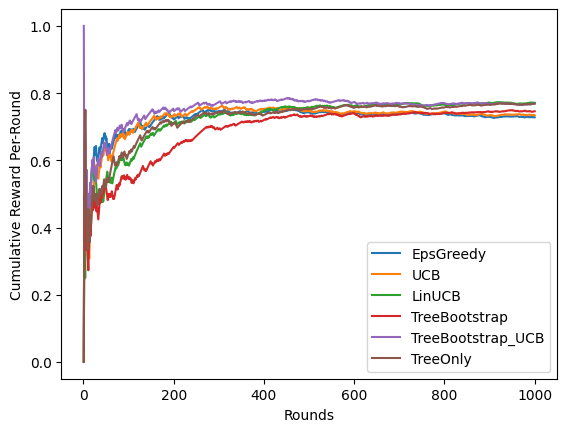

In [41]:
# plot cumulative reward per round
eg_results, ucb_results, linucb_results, tbs_results, tbucb_results, only_results, round_list = [], [], [], [], [], [], [] # create lists
n_rounds = 1000                            # the total number of rounds
eg_sum, ucb_sum,linucb_sum, tbs_sum, tbucb_sum, only_sum = 0, 0, 0, 0, 0, 0 # set the initial reward sum

# nラウンドまでの累積報酬 / ラウンド数n = 平均報酬
# get the 800 results from the previous run per each algorithm
for n_round in range(1, n_rounds + 1):              # start from 1 to avoid zero devision error
    eg_sum += results_EpsGreedy[n_round-1]
    ucb_sum += results_UCB[n_round-1]
    linucb_sum += results_LinUCB[n_round-1]
    tbs_sum += results_TreeBootstrap[n_round-1]
    tbucb_sum += results_TreeBootstrap_UCB[n_round-1]
    only_sum += results_TreeBootstrap_Only[n_round-1]
    eg_results.append(eg_sum/n_round)
    ucb_results.append(ucb_sum/n_round)
    linucb_results.append(linucb_sum/n_round)
    tbs_results.append(tbs_sum/n_round)
    tbucb_results.append(tbucb_sum/n_round)
    only_results.append(only_sum/n_round)
    round_list.append(n_round)

# plot the results
plt.plot(round_list,eg_results, label = "EpsGreedy")
plt.plot(round_list,ucb_results, label = "UCB")
plt.plot(round_list,linucb_results, label = "LinUCB")
plt.plot(round_list,tbs_results, label = "TreeBootstrap")
plt.plot(round_list, tbucb_results, label = "TreeBootstrap_UCB")
plt.plot(round_list, only_results, label = "TreeOnly")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()


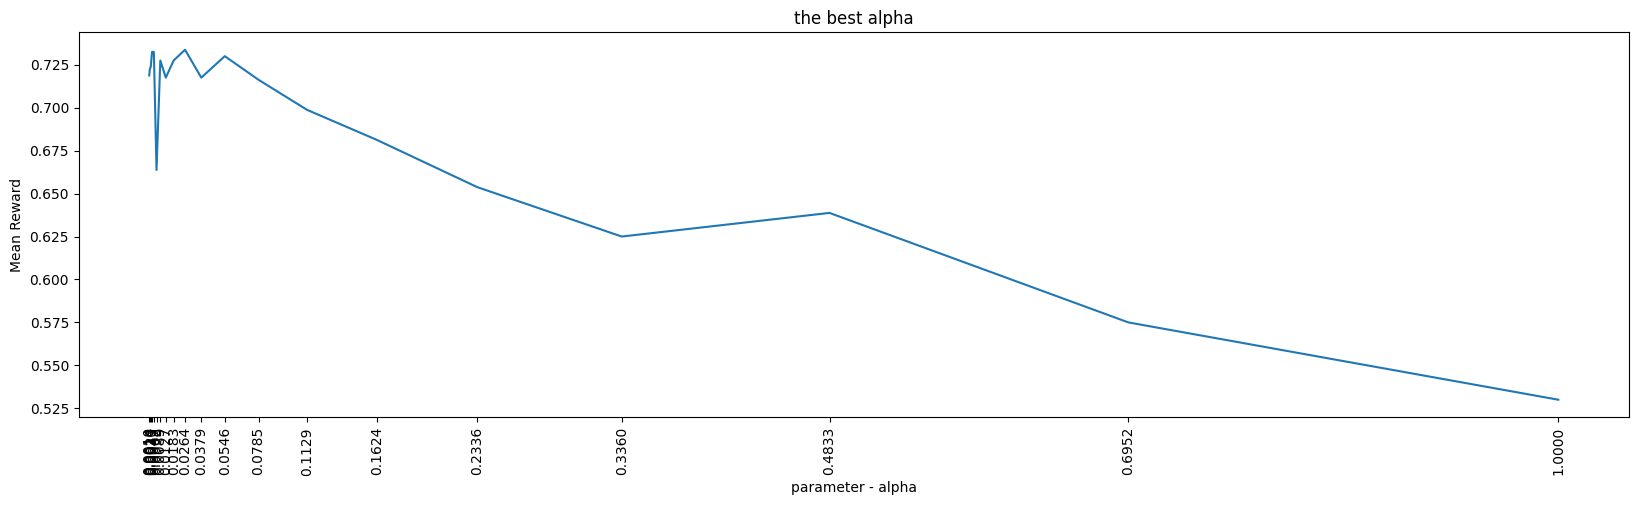

The best alpha for LinUCB is 0.026 with reward 0.73375


In [29]:
# hyperparameter optimization
alpha_list = np.logspace(-3,0,num= 20)    # generate valid alpha values
n_rounds = 800                            # set the initial number of round
max_reward = -np.inf                      # set the initial max reward
best_alpha = None                         # set the initial best alpha
results = []

# run with a set of alpha
for alpha in alpha_list:
    grid_mab = LinUCB(10, 10, alpha)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    results.append(temp_result)
    if temp_result > max_reward:  # get the maximum mean rewards with the best alpha
        best_alpha = alpha
        max_reward = temp_result


# show the plot
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(alpha_list,results)
plt.xticks(alpha_list, rotation = 'vertical')
plt.title('the best alpha')
plt.ylabel('Mean Reward')
plt.xlabel('parameter - alpha')
plt.show()
print("The best alpha for LinUCB is", round(best_alpha, 3), "with reward", max_reward)

#The best alpha for LinUCB is 0.026 with reward 0.73375


## 6. Implement KernelUCB contextual MAB

In [30]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.

    eta : float
        Positive real explore-exploit parameter.

    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        if not (type(gamma) == float  or gamma.dtype == 'float64'):
            raise TypeError("`gamma` must be float type")
        if not np.isreal(gamma):
            raise ValueError("`gamma` must be a real number")
        if not (type(eta) == float  or eta.dtype == 'float64'):
            raise TypeError("`eta` must be float type")
        if not np.isreal(eta):
            raise ValueError("`eta` must be a real number")

        self.n_dims = n_dims                # the number of dimension
        self.gamma = gamma                  # regularization parameter
        self.eta  = eta                     # exploration parameter
        self.kern = kern                    # kernel function
        self.inv_K = None                   # inversed kernel matrices
        self.u = np.zeros(self.n_arms)      # upper bounds of probability
        self.y = np.empty(0)                # reward history
        self.pre_x = np.empty(0)            # collect the previous contexts(x) for b
        self.n_round = 0                    # count the number of round

    # return the arm with the highest upper bounds of rewards
    def play(self, context):
        super().play(context)
        if self.n_round == 0:               # set the initial upper bound reward
            self.u[0] = 1.0
        else:
            k = self.kern(context, self.pre_x)         # calculate all kernel fn for previous contexts
            for arm in range(self.n_arms):
                shaped_context = context[arm].reshape(1, -1)
                sigma = np.sqrt(self.kern(shaped_context, shaped_context) - k[arm] @ self.inv_K  @ k[arm])   # calculate width (sigma)
                self.u[arm] = k[arm] @ self.inv_K @ self.y + (self.eta / np.sqrt(self.gamma)) * sigma        # calculate upper bound

        arm = break_tie(self.u)
        return arm

    def update(self, arm, reward, context):
        shaped_context = context[arm].reshape(1, -1)            # reshape context
        shaped_reward = np.array(reward).reshape(1, -1)         # reshape reward

        if self.n_round == 0:                                   # set the first values
            self.y = shaped_reward
            self.pre_x = shaped_context
            self.K = self.kern(shaped_context, shaped_context) + self.gamma
            self.inv_K  = 1 / (self.K)

        else:
            self.y = np.r_[self.y, shaped_reward]               # update reward
            k = self.kern(context, self.pre_x)                  # calculate k (xa,t)
            b = k[arm].reshape(self.n_round, 1)

            bT_invK = b.T @ self.inv_K                          # previously calculate expensive calculation
            invK_b = self.inv_K  @ b
            K22 = np.linalg.inv(self.kern(shaped_context, shaped_context) + self.gamma - bT_invK @ b)
            K11 = self.inv_K + K22 * invK_b @ bT_invK
            K12 = - K22 * invK_b
            K21 = - K22 * bT_invK

            self.pre_x = np.r_[self.pre_x, shaped_context]      # update previous context
            self.inv_K = np.vstack((np.hstack((K11, K12)), np.hstack((K21, K22))))    # update inverse K value

        self.n_round += 1



In [31]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))


KernelUCB average reward 0.73625


In [32]:
# hyperparameter optimization
gamma_list = np.linspace(0, 1, num = 11)[1:]       # generate valid gamma values & remove 0.0
eta_list = np.linspace(0, 0.5, num = 11)[1:]       # generate valid eta values & remove 0.0
n_rounds = 800                                     # set the initial number of round
gam_max_reward, eta_max_reward = -np.inf, -np.inf  # set the initial max reward for gamma and eta

# get the maximum mean rewards with the the initial eta
eta = 0.1
for gam in gamma_list:
    grid_mab = KernelUCB(10, 10, gam, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > gam_max_reward:      # get the maximum mean rewards with the best eta and gamma
        gam_max_reward = temp_result
        best_gamma = gam

print("The best gamma for Kernel UCB is {", round(best_gamma, 3), "} with reward", gam_max_reward)

for eta in eta_list:
    grid_mab = KernelUCB(10, 10, best_gamma, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > eta_max_reward:   # get the maximum mean rewards with the best gamma
        eta_max_reward = temp_result
        best_eta =  eta

print("The best eta for Kernel UCB is {", round(best_eta, 3), "} with reward", eta_max_reward)


The best gamma for Kernel UCB is { 0.1 } with reward 0.79375
The best eta for Kernel UCB is { 0.15 } with reward 0.7375


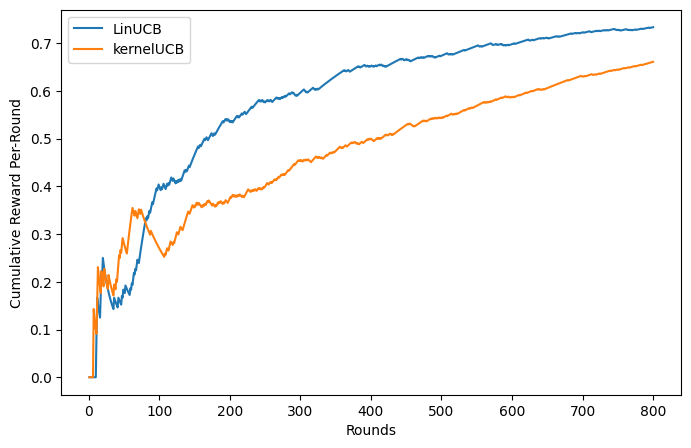

In [33]:
# your plotting code here LinUCB vs Kernel UCB
best_lin_results, best_ker_results, round_list = [], [], []        # create lists for results
n_rounds = 800                                                     # the total number of rounds
best_lin_sum, best_ker_sum = 0, 0                                  # set the initial reward sum

best_lin_mab = LinUCB(10, 10, best_alpha)
best_results_LinUCB = offlineEvaluate(best_lin_mab, arms, rewards, contexts,800)

# run UCB algorithms
best_kernel_mab = KernelUCB(10, 10, best_gamma, best_eta , rbf_kernel)
best_results_KernelUCB = offlineEvaluate(best_kernel_mab, arms, rewards, contexts, 800)

for n_round in range(1, n_rounds + 1):
    best_lin_sum += best_results_LinUCB[n_round-1]
    best_ker_sum += best_results_KernelUCB[n_round-1]

    # append ccumulative rewards
    best_lin_results.append(best_lin_sum/n_round)
    best_ker_results.append(best_ker_sum/n_round)
    round_list.append(n_round)

# plot
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(round_list, best_lin_results, label = "LinUCB")
plt.plot(round_list, best_ker_results, label = "kernelUCB")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()
